In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from helpers_train import load_train_dataset, train_data_preprocessing

In [3]:
folder_path = "processed_data/train"
data_df = load_train_dataset(folder_path)
data_df.sample(10)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  7.53file/s]


,ax,ay,az,wx,wy,wz,angleX,angleY,angleZ,label
29644,0.2632,-0.2749,-0.4512,-84.5947,44.2505,90.6982,-124.7443,-6.5314,-53.0750,running
74129,0.2580,-0.0170,-3.2780,22.8880,109.8020,62.9880,172.5130,12.9750,76.3280,running
11548,-0.9185,0.4805,0.0430,43.7622,-16.4185,77.7588,75.4980,48.7683,-52.2235,walking
5486,-1.5796,-1.4980,0.1729,146.7285,-53.0396,80.6885,-68.7305,37.8259,-131.7206,climbing
15016,-0.7876,0.3804,-0.1304,-63.7817,64.3921,41.8091,126.7657,57.4969,-74.7235,walking
59132,0.1960,0.3660,0.1120,-18.8600,-93.4450,-160.7060,177.9570,20.5660,-77.3160,running
22457,0.0986,0.8037,-0.3833,19.2261,-2.9297,4.7607,112.3077,-9.8602,-114.1425,walking
15614,-0.6016,0.3271,-0.7466,38.7573,-5.2490,-29.7852,159.4830,37.3975,108.8800,walking
25759,0.3423,-0.4321,-0.6509,36.9873,13.7939,0.8545,-114.7247,-3.6475,51.2402,running
9936,-0.3643,-0.7480,-0.2515,-383.4229,182.0068,-125.1831,-134.1046,23.3350,121.1243,climbing


In [4]:
features = data_df.iloc[:, :-1]
labels = data_df['label']

print("Features shape: ", features.shape)
print("Labels shape: ", labels.shape)

Features shape:  (285905, 9)
Labels shape:  (285905,)


In [5]:
features_scaled, labels_categorical = train_data_preprocessing(
    features, labels)
print("Features shape: ", features_scaled.shape)
print("Labels shape: ", labels_categorical.shape)

Features shape:  (285905, 9)
Labels shape:  (285905, 5)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
import numpy as np


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(LSTM, self).__init__()

        self.layers = nn.ModuleList()
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                self.layers.append(
                    nn.LSTM(input_size, hidden_size, batch_first=True))
            else:
                self.layers.append(
                    nn.LSTM(hidden_sizes[i-1], hidden_size, batch_first=True))
            setattr(self, f'dropout{i+1}', nn.Dropout(0.3))

        # self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        # self.dropout1 = nn.Dropout(0.3)

        # self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        # self.dropout2 = nn.Dropout(0.3)

        self.flatten = nn.Flatten()

        # nn.Linear(<i/p dim>, <o/p dim>)
        self.fc1 = nn.Linear(hidden_size, 2048)
        self.dropout5 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(2048, 4096)
        self.dropout6 = nn.Dropout(0.3)

        # self.fc3 = nn.Linear(4096, 1024)
        # self.dropout7 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(4096, num_classes)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x, _ = layer(x)
            dropout = getattr(self, f'dropout{i+1}')
            x = dropout(x)

        x = self.flatten(x)

        x = nn.functional.relu(self.fc1(x))
        x = self.dropout5(x)

        x = nn.functional.relu(self.fc2(x))
        x = self.dropout6(x)

        # x = nn.functional.relu(self.fc3(x))
        # x = self.dropout7(x)

        x = self.fc4(x)

        return x

In [7]:
# Split the data into training and testing sets
from tqdm import tqdm

features_train, features_test, labels_train, labels_test = train_test_split(
    features_scaled, labels_categorical, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
features_train_tensor = torch.tensor(features_train, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train.argmax(
    axis=1), dtype=torch.long)
features_test_tensor = torch.tensor(features_test, dtype=torch.float32)


# DataLoader for training
batch_size = 256
train_dataset = TensorDataset(features_train_tensor, labels_train_tensor)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size)

# DataLoader for validation
features_valid_tensor = torch.tensor(features_test, dtype=torch.float32)
labels_valid_tensor = torch.tensor(labels_test.argmax(
    axis=1), dtype=torch.long)  # Assuming one-hot encoding
valid_dataset = TensorDataset(features_valid_tensor, labels_valid_tensor)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=batch_size)

# Instantiate the model
input_size = features_train_tensor.shape[-1]
hidden_sizes = [1028, 1028]
num_classes = 5
lstm_model = LSTM(input_size, hidden_sizes, num_classes)

# Define optimizer and loss function
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [8]:
num_epochs = 20
early_stopping_patience = 3
best_valid_loss = float('inf')
no_improvement_count = 0

for epoch in range(num_epochs):
    # Training phase
    lstm_model.train()
    train_loss = 0.0
    train_batches = len(train_dataloader)

    with tqdm(total=train_batches, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as t:
        for batch_features, batch_labels in train_dataloader:
            optimizer.zero_grad()
            output = lstm_model(batch_features.unsqueeze(1))
            loss = criterion(output, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            t.set_postfix({'loss': loss.item()})
            t.update()

    avg_train_loss = train_loss / train_batches
    print(f'Average Training Loss: {avg_train_loss}')

    # Validation phase
    lstm_model.eval()
    valid_loss = 0.0
    valid_batches = len(valid_dataloader)

    with torch.no_grad():
        for batch_features, batch_labels in valid_dataloader:
            output = lstm_model(batch_features.unsqueeze(1))
            loss = criterion(output, batch_labels)
            valid_loss += loss.item()

    avg_valid_loss = valid_loss / valid_batches
    print(f'Average Validation Loss: {avg_valid_loss}')

    # Early stopping check
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stopping_patience:
        print(f'Early stopping after {epoch+1} epochs without improvement.')
        break

Epoch 1/20: 100%|██████████| 1787/1787 [07:04<00:00,  4.21batch/s, loss=0.573]


Average Training Loss: 0.7293108439372116
Average Validation Loss: 0.5858661389057535


Epoch 2/20: 100%|██████████| 1787/1787 [07:20<00:00,  4.06batch/s, loss=0.486]


Average Training Loss: 0.603123765470065
Average Validation Loss: 0.5491267638718522


Epoch 3/20: 100%|██████████| 1787/1787 [07:17<00:00,  4.08batch/s, loss=0.504]


Average Training Loss: 0.5708783919009405
Average Validation Loss: 0.51813829485202


Epoch 4/20: 100%|██████████| 1787/1787 [06:53<00:00,  4.33batch/s, loss=0.52] 


Average Training Loss: 0.5533015852742977
Average Validation Loss: 0.5292166527485688


Epoch 5/20: 100%|██████████| 1787/1787 [06:54<00:00,  4.31batch/s, loss=0.486]


Average Training Loss: 0.5375914347191796
Average Validation Loss: 0.519710216879578


Epoch 6/20: 100%|██████████| 1787/1787 [07:28<00:00,  3.99batch/s, loss=0.536]


Average Training Loss: 0.5261848269558913
Average Validation Loss: 0.4707121149005506


Epoch 7/20: 100%|██████████| 1787/1787 [10:33<00:00,  2.82batch/s, loss=0.502]


Average Training Loss: 0.5153962915078447
Average Validation Loss: 0.4655301266868643


Epoch 8/20: 100%|██████████| 1787/1787 [10:32<00:00,  2.82batch/s, loss=0.46] 


Average Training Loss: 0.5062919336120443
Average Validation Loss: 0.4592946908484636


Epoch 9/20:  70%|███████   | 1251/1787 [05:34<02:23,  3.74batch/s, loss=0.472]


KeyboardInterrupt: 

In [ ]:
# Save the model
torch.save(lstm_model.state_dict(), 'utils/lstm_model.pth')

In [ ]:
f

NameError: name 'f' is not defined

In [ ]:
from helpers_test import make_prediction, read_file, test_data_preprocessing

In [ ]:
# Process Raw Data
file_path = "processed_data/test/test1.csv"
test_data_df = read_file(file_path)
test_data_df

,ax,ay,az,wx,wy,wz,angleX,angleY,angleZ,labels
0,-0.515,0.024,-0.869,20.569,-4.700,28.137,175.567,28.460,96.081,climbing
1,-0.504,0.024,-0.869,20.569,-4.700,28.137,175.616,28.488,95.757,climbing
2,-0.504,0.024,-0.875,22.888,-5.432,26.062,175.682,28.526,95.444,climbing
3,-0.493,0.024,-0.875,22.888,-5.432,26.062,175.770,28.564,95.147,climbing
4,-0.493,0.048,-0.879,24.292,-4.700,22.949,175.875,28.603,94.861,climbing
...,...,...,...,...,...,...,...,...,...,...
16179,-0.460,0.012,-0.893,1.526,2.686,6.653,-179.594,25.598,-0.687,walking
16180,-0.464,0.012,-0.893,1.526,2.686,6.653,-179.599,25.576,-0.758,walking
16181,-0.464,0.010,-0.889,-1.526,0.366,3.845,-179.615,25.565,-0.813,walking
16182,-0.450,0.010,-0.889,-1.526,0.366,3.845,-179.643,25.565,-0.851,walking


In [ ]:
labels = test_data_df['labels']
test_data_df = test_data_df.iloc[:, :-1]

In [ ]:
scaled_data = test_data_preprocessing(test_data_df)

In [ ]:
# Reshape X to be 3D for LSTM input (samples, time steps, features)
n_samples, n_features = scaled_data.shape
scaled_data = scaled_data.reshape((n_samples, 1, n_features))

In [ ]:
# Make predictions
all_actions, one_action = make_prediction(lstm_model, scaled_data)
print("All actions: ", all_actions)
print("One action: ", one_action)

506/506 [==============================] - 1s 888us/step
All actions:  ['sitting' 'sitting' 'sitting' ... 'climbing' 'climbing' 'climbing']
One action:  lying


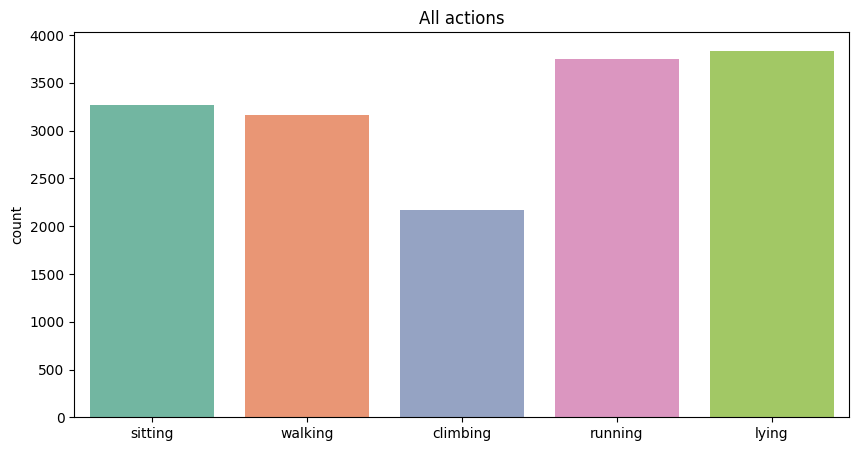

In [ ]:
# Draw a freq chart for all actions, different colors for each action
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(x=all_actions, palette="Set2")
plt.title('All actions')
plt.show()

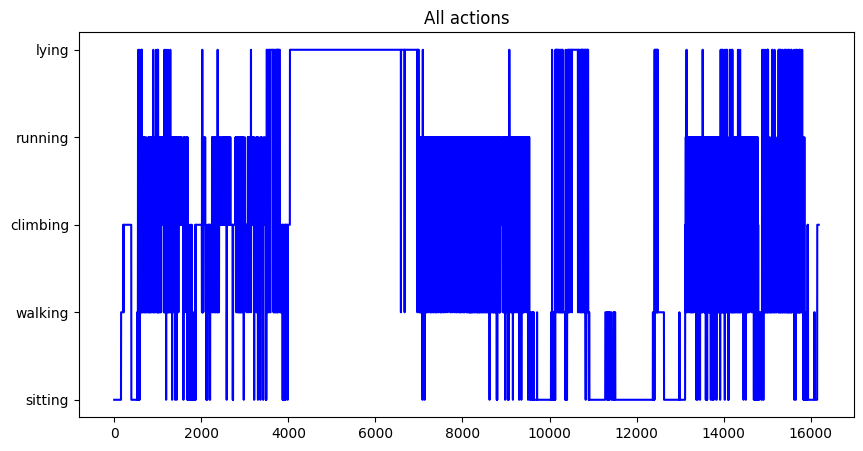

In [ ]:
# Draw a line chart for all actions, different colors for each action
plt.figure(figsize=(10, 5))
plt.plot(all_actions, color='blue')
plt.title('All actions')
plt.show()

In [ ]:
# Accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(labels, all_actions)

0.6138779041028176